# Assignment 3 - Partial Differential Equations

In this assignment, you will find numerical solutions to partial differential equations.  In particular, you will use an implicit method for solving the diffusion equation, considering problems with both Dirichlet and Neumann boundary conditions.

In each part of this assignment, you will be asked to write some code in the cell indicated.  If you find it convenient to break your code up over multiple cells, please do so.  You will also be asked to discuss your code and results obtained in a text cell.

You should use numpy and scipy libraries where appropriate. You will always be told explicitly if you should **not** use a particular library.  Make sure to comment your code.  Make sure all cells run from a freshly started notebook before you submit your work.

## The Diffusion Equation

In this assignment, you will find numerical solutions to the diffusion equation.

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
}$$

$$b = \pmatrix{
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
}$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

Your code should construct the matrix equation including boundary value term, and solve it using an appropriate linear algebra routine from scipy. You should verify your results, and quantify the uncertainties due to the method.  Discuss your results in the cell below.

In [1]:
import numpy as np
import scipy
from scipy import linalg
import math
import matplotlib.pyplot as plt
from scipy import integrate

def M_Matrix_Create(N_x, alpha, Condition):
    """
    
    Parameters
    ----------
    N_x : Integer
        Discretized space points along a poker.
    alpha : Float
        This is just a constant for visual clarity.
    Condition : String
        This value is to determine whether to use either Dirichlet or
        Neumann Boundary Conditions (BCs).

    Returns
    -------
    M_Matrix : numpy array
        This matrix is a collection of constant terms used in the matrix
        equation with the square shape: (N_x-2). Dependent on Condition
        parameter whether to use Dirichlet or Neumann boundary conditions.

    """
    M_Matrix = np.zeros(shape=(N_x-2,N_x-2))

    for i in range(N_x-2):
        if i == 0:
            M_Matrix[i][i] = 1+2*alpha
            M_Matrix[i][i+1] = -alpha
            
        elif i == N_x-3:
            
            M_Matrix[i][i-1] = -alpha
            
            if Condition == 'Dirichlet': # Dirichlet Boundary Conditions.

                M_Matrix[i][i] = 1+2*alpha
            
            elif Condition == 'Neumann': # Neumann Boundary Conditions.

                M_Matrix[i][i] = 1+alpha
        else:
    
            M_Matrix[i][i-1] = -alpha
            M_Matrix[i][i] = 1+2*alpha
            M_Matrix[i][i+1] = -alpha
 
    return M_Matrix    
    

def b_Matrix_Create(N_x, alpha, Condition):
    """
    
    Parameters
    ----------
    N_x : Integer
        Discretized space points along a poker.
    alpha : Float
        This is just a constant for visual clarity.
    Condition : String
        This value is to determine whether to use either Dirichlet or
        Neumann Boundary Conditions (BCs).

    Returns
    -------
    b_Matrix : numpy array
        This matrix is a Boundary vector term used in the matrix
        equation with the single column shape: (N_x-2). Dependent on Condition
        parameter whether to use Dirichlet or Neumann boundary conditions.

    """
    b_Matrix = np.zeros(shape=(N_x-2,1))
    for i in range(N_x-2):
        if i == 0:
                b_Matrix[0][0] = -alpha*Temperature_Fire
                
        elif i == N_x-3:
            if Condition == 'Dirichlet': # Dirichlet Boundary Conditions.
            
                b_Matrix[i][0] = -alpha*Temperature_Ice
                
            elif Condition == 'Neumann': # Neumann Boundary Conditions.

                b_Matrix[i][0] = 0
          
    return b_Matrix
   
def U_Matrix_0_Create(N_x, alpha):
    """
    
    Parameters
    ----------
    N_x : Integer
        Discretized space points along a poker.
    alpha : Float
        This is just a constant for visual clarity.

    Returns
    -------
    U_Matrix_0 : numpy array
        This is a single collumn matrix with shape: (N_x-2). Is the collection 
        of equillibrium temperature terms used as the 0th term for the U matrix
        in the matrix equation.

    """
    U_Matrix_0 = np.zeros(shape=(N_x-2,1))
    for i in range(N_x-2):
        U_Matrix_0[i][0] = Temperature_Room
    
    return U_Matrix_0
   

def plot_scatter_1dheat(x, y, title, xaxislabel, yaxislabel, Label, heatmap):
    """
    
    Parameters
    ----------
    x : numpy array / List
        Used as the x data for the x axis on a x vs y graph plot.
    y : numpy array / List
        Used as the y data for the y axis on a x vs y graph plot.
    title : String
        Title for the graph.
    xaxislabel : String
        Labels the x axis on a x vs y graph plot.
    yaxislabel : String
        Labels the y axis on a x vs y graph plot..
    Label : String
        Labels the data on the graph into a legend.
    heatmap : Bool
        Sets whether to print heat map, true for heatmap, false for no heatmap.

    Returns
    -------
    Returns a 1 dimensional heatmap (if heatmap==True) and scatter graph.

    """
    
    if heatmap == True:
        
        plt.rcParams["figure.figsize"] = 15,2 # set size of plots in inches x,y.
        fig, ax = plt.subplots()
        
        plt.title("1D Heatmap for IFDM solution of Temperature vs Position") # Labels title.
        plt.xlabel(xaxislabel) 
        
        y_sum = np.array(y) # Convert to array, as list wont work here.
        # Plot 1d heatmap.
        extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
        plot = ax.imshow(y_sum[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
        plot
        ax.set_yticks([])
        ax.set_xlim(extent[0], extent[1])
        fig.colorbar(plot,label='Temperature (K)')
        
        plt.show() 


    plt.rcParams["figure.figsize"] = 10,5 # set size of plots in inches x,y.
    fig, ax = plt.subplots()
    
    plt.title(title) # Labels title.
    
    # Scientific notation.
    ax.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    
    # Labels axis.
    plt.xlabel(xaxislabel) 
    plt.ylabel(yaxislabel)
    
    plt.grid(True) # Adds grid to graph.
    # Plot scatter graph.
    plt.plot(x, y,label = Label) 
    plt.gca().legend() # plots the legend.
    
    plt.show()      

def plot_scatter(x,y,Label):
    """
    
    Parameters
    ----------
    x : numpy array / List
        Used as the x data for the x axis on a x vs y graph plot.
    y : numpy array / List
        Used as the y data for the y axis on a x vs y graph plot.
    Label : String
        Labels the data on the graph into a legend.

    Returns
    -------
    This returns a plot of a single scatter graph, to be used when plotting 
    multiple sets of data onto a single graph for clarity.

    """
    plt.plot(x, y, marker='.', linestyle='', label = Label)


def Heat_Diffusion_Solver(Time, Tau, Condition):
    """
    
    Parameters
    ----------
    Time : Integer
        This is the total time value to evaluate IFDM to.
    Tau : Float
        This is the time step value for IFDM.
    Condition : String
        This value is to determine whether to use either Dirichlet or
        Neumann Boundary Conditions (BCs).

    Returns
    -------
    Distance, U_List ; List , List
    This function solves the heat-diffusion equation via IFDM in matrix form.
    It returns the discretized space points along the poker as a list and 
    the temperature evaluated at each of the space points at time, Time.

    """
    # Create variables for tidiness.
    alpha = Poker_Thermal_Diffusivity*Tau/h**2 # A constant for ease of writing.
    N_x=int(Poker_Length/h) # Number of distance steps including boundaries.
    
    # Creates the U matrix values at time = 0 i.e. at initial equillibrium,
    # for the correct boundary conditions.
    U_Matrix = U_Matrix_0_Create(N_x, alpha) 
    # Creates the b matrix - boundary vector for the correct boundary condition.
    b_Matrix = b_Matrix_Create(N_x, alpha, Condition) 
    
    # LU decomposition of M_Matrix
    LU, piv = linalg.lu_factor(M_Matrix_Create(N_x, alpha, Condition),
                               check_finite=False)
    
    
    Distance = []
    for i in np.linspace(h,Poker_Length-h,num = (N_x-2)): 
        Distance.append(i)
        
    # Run loop to calculate temp value for all space points at time, Time.
    # Using time step, Tau.
    for i in range(int((Time/Tau))): 
        #print(i)
        U_Matrix_N_Next = linalg.lu_solve((LU, piv), (U_Matrix-b_Matrix),
                                          check_finite=False)
        U_Matrix = U_Matrix_N_Next
        
    
        
    
    # Prepare data for plotting
    U_List = list(U_Matrix.flatten()) # Converts a 1D column matrix to list
    U_List.insert(0,Temperature_Fire) # Add the Fire/furnace boundary
    
    
    Distance.insert(0,0) # Add the position for the start of poker.
    
    
    return Distance, U_List
 

def Fourier_solution(Time):
    """
    
    Parameters
    ----------
    Time : Float
        This is the time to evaluate to.

    Returns
    -------
    Distance, U_Final ; List, List.
    This function solves the heat-diffusion equation via the anlytical Fourier
    soluition.
    It returns the discretized space points along the poker as a list and 
    the temperatures evaluated at each of the space points (as a list) at time,
    Time. It evaluates 100 values in the sum for each spacepoint value.
    
    """
    def f1(x):
        """
        
        Parameters
        ----------
        x : Float
            Integration variable.

        Returns
        x : float
        -------
        Term to allow for integration in Fourier_Solution()

        """
        return x
    
    def f2(x,n):
        """
        
        Parameters
        ----------
        x : Float
            Integration variable.
        n : Integer
            Integer to determine the order of coefficients and sums in
            the Fourier solution.

        Returns
        math.sin(n*math.pi*x/Poker_Length) : float
        -------
        Term to allow for integration in Fourier_Solution()

        """
        return math.sin(n*math.pi*x/Poker_Length)
    
    
    Distance = [] # Distance along the poker.
    U_Final = [] # Solutions for all positions at a set time tau.


    for i in np.linspace(0,Poker_Length,num = (int(Poker_Length/h))):
        
        # Set the Sum term to zero for each value of position/distance/x.
        SUM_Term = 0 
        # Sections of the Fourier Solution for simplicity.
        U_PART2 = (Temperature_Ice-Temperature_Fire)/(Poker_Length) 
        U_E = (Temperature_Fire + U_PART2*i) 
        
        # Create spacepoint list.
        Distance.append(i) 
        
        # This calculates the Sum term with the coefficients of the fourier.
        # solution, using the order N = 100 i.e 100 summed terms.
        for n in np.linspace(1,100,100):
            
            integral, error = integrate.quad(lambda x: ((Temperature_Room
                                                        - (Temperature_Fire 
                                                        + U_PART2*f1(x)))
                                                        * f2(x,n))
                                                        , 0 # Integral limits.
                                                        , Poker_Length) 
            B_n = (2/Poker_Length)*integral # Coefficient term
            SUM_Term += (f2(i,n)*B_n*math.exp(-Poker_Thermal_Diffusivity
                                              *Time
                                              *((n*math.pi)/(Poker_Length))**2)) 

          
        
        U_Final.append(U_E+SUM_Term) 
        
    # Prints integration error for discussion/analysis   
    print('Integration error per coefficient: '+ str(error))
    
    # Preparing lists for plotting
    U_Final = np.array(U_Final) 
    Distance = Distance[:-1] # Removes spacepoint that is in the ice bath.
    U_Final = U_Final[:-1] # Removes Temnp value that is in the ice bath.
    
    return Distance, U_Final

def Gradient_Checker(x,y):
    """
    
    Parameters
    ----------
    x : List
        x axis data.
    y : List
        y axis data.

    Returns
    -------
    m : Float
        Gradient of the slope for the x vs y plot.

    """
    x = np.array(x)
    y = np.array(y)
    m = (((np.mean(x)*np.mean(y)) 
      - np.mean(x*y)) 
     /((np.mean(x)**2) 
       - np.mean(x**2)))
    return m

In [2]:
# Constants - Poker.
Poker_Thermal_Conductivity = 59 # W/(m*K)
Poker_Specific_Heat = 450 # J/(kg*K)
Poker_Density = 7900 # kg/m3
Poker_Length = 0.5 # m
Poker_Thermal_Diffusivity = Poker_Thermal_Conductivity/(Poker_Density
                                                        *Poker_Specific_Heat) # m**2/s
h = 0.005 # Discretized spacepoints along poker, m.

# Constants - Temperature.
Temperature_Room = 20 + 273.15 # K
Temperature_Ice = 0 + 273.15 # K
Temperature_Fire = 1000 + 273.15 # K


In [3]:
# Boundary Condition.
Condition = 'Dirichlet'# 'Neumann' # 'Dirichlet'

# Parameters for IDFM solution.
Time_10 = 10 # Total time elapsed, s.
Tau_01 = 0.1 # Time step size, s.

# Run the IFDM solution.
Distance_0005, U_List_10_01 = Heat_Diffusion_Solver(Time_10
                                                     , Tau_01
                                                     , Condition)
# Run the Fourier Solution when Time = 10s, h = 0.005m.
Distance_Fourier, U_Final_10 = Fourier_solution(Time_10)

Integration error per coefficient: 8.222834465648991e-11


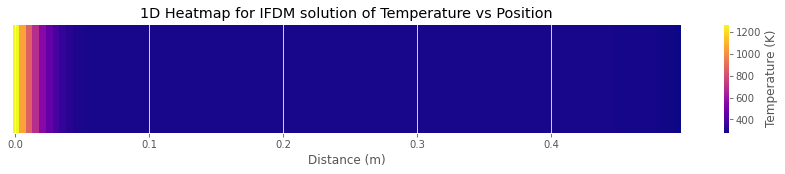

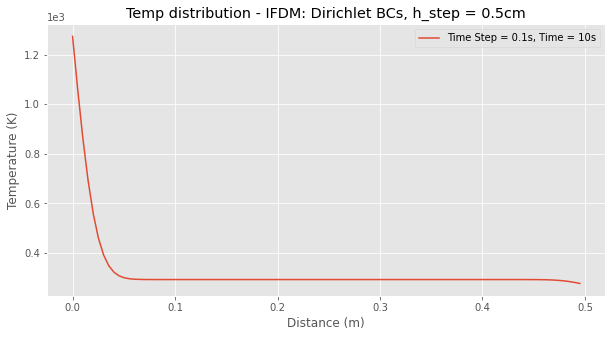

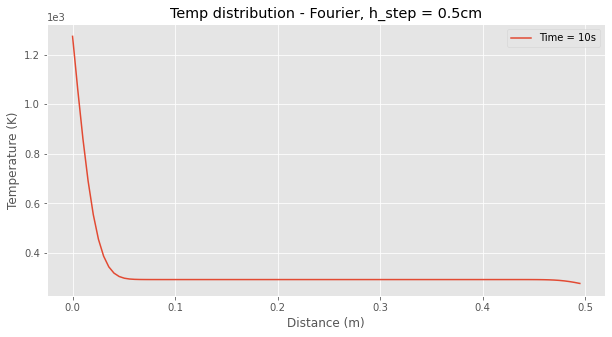

In [4]:
# Plot data, style and label - IDFM: Time= 10s, Tau = 0.1s, h = 0.005m.
with plt.style.context('ggplot'): # Styles the plot.
    
    Label = str("Time Step = " + str(Tau_01) 
                + "s, " + "Time = "+str(Time_10)+"s")
    plot_scatter_1dheat(Distance_0005
                        , U_List_10_01
                        , 'Temp distribution - IFDM: ' + str(Condition) + ' BCs'
                        + ', h_step = ' + str(h*100) + "cm"
                        , 'Distance (m)'
                        , 'Temperature (K)'
                        , Label, True)
# Plot Fourier Solution when Time = 10s, h = 0.005m.
with plt.style.context('ggplot'): # Styles the plot
    
    Label = str("Time = " + str(Time_10) + "s")
    plot_scatter_1dheat(Distance_Fourier
                        , U_Final_10
                        , 'Temp distribution - Fourier, h_step = '
                        + str(h*100) + "cm"
                        , 'Distance (m)'
                        , 'Temperature (K)'
                        , Label, False)

In [5]:
# Boundary Condition.
Condition = 'Dirichlet'# 'Neumann' # 'Dirichlet'

# Parameters for IDFM solution.
Time_500 = 500 # Total time elapsed, s.
Tau_01 = 0.1 # Time step size, s.

# Run the IFDM solution.
Distance_0005, U_List_500_01 = Heat_Diffusion_Solver(Time_500
                                                       , Tau_01
                                                       , Condition)
# Run the Fourier Solution when Time = 500s, h = 0.005m.
Distance_Fourier, U_Final_500 = Fourier_solution(Time_500)

Integration error per coefficient: 8.222834465648991e-11


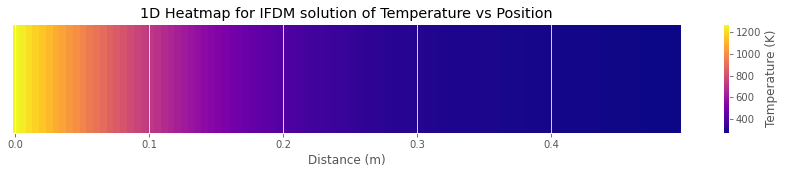

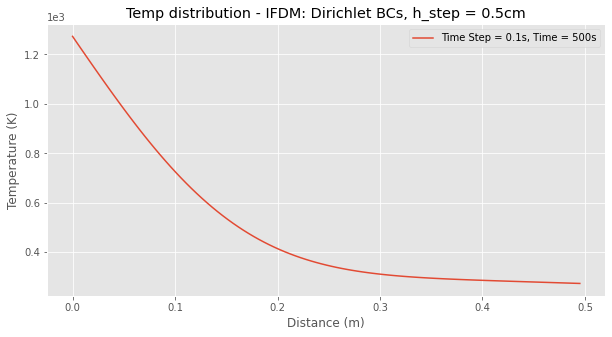

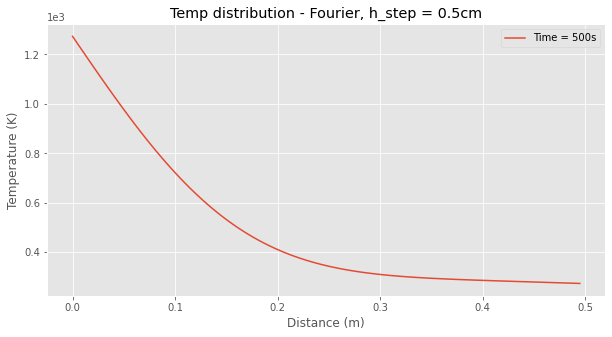

In [6]:
# Plot data, style and label  - IDFM: Time= 500s, Tau = 0.1s, h = 0.005m
with plt.style.context('ggplot'): # Styles the plot.
    
    Label = str("Time Step = " + str(Tau_01) 
                + "s, " + "Time = " + str(Time_500) + "s")
    plot_scatter_1dheat(Distance_0005
                        , U_List_500_01
                        ,'Temp distribution - IFDM: '+ str(Condition) +' BCs'
                        + ', h_step = '+ str(h*100) + "cm"
                        , 'Distance (m)'
                        , 'Temperature (K)'
                        , Label, True)
# Plot Fourier Solution when Time = 500s, h = 0.005m.
with plt.style.context('ggplot'): # Styles the plot
    
    Label = str("Time = "+str(Time_500)+"s")
    plot_scatter_1dheat(Distance_Fourier
                        , U_Final_500
                        , 'Temp distribution - Fourier, h_step = '
                        + str(h*100)+"cm"
                        , 'Distance (m)'
                        , 'Temperature (K)'
                        , Label, False)

In [7]:
# Boundary Condition.
Condition = 'Dirichlet'# 'Neumann' # 'Dirichlet'

# Parameters for IDFM solution.
Time_1000 = 1000 # Total time elapsed, s.
Tau_01 = 0.1 # Time step size, s.

# Run the IFDM solution
Distance_0005, U_List_1000_01 = Heat_Diffusion_Solver(Time_1000
                                                         , Tau_01
                                                         , Condition)
# Run the Fourier Solution when Time = 1000s, h = 0.005m.
Distance_Fourier, U_Final_1000 = Fourier_solution(Time_1000)

Integration error per coefficient: 8.222834465648991e-11


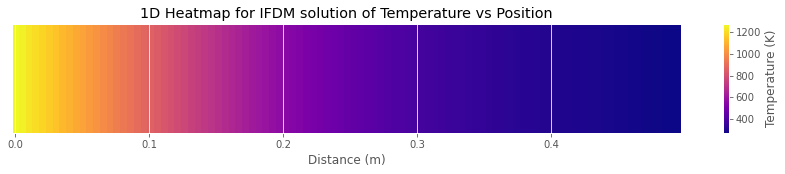

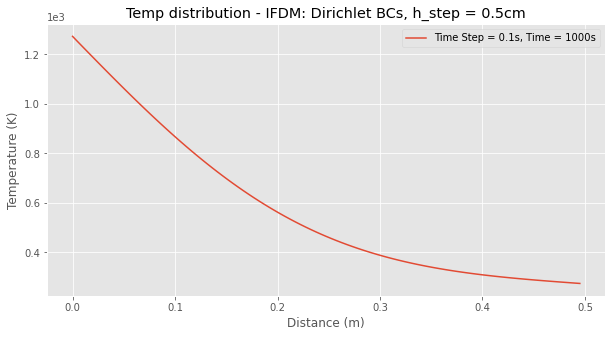

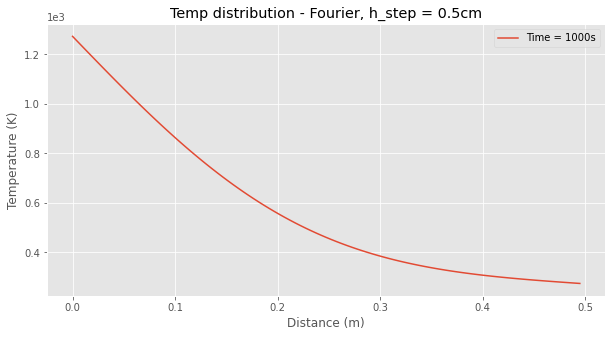

In [8]:
# Plot data, style and label  - IDFM: Time= 1000s, Tau = 0.1s, h = 0.005m.
with plt.style.context('ggplot'): # Styles the plot.
    
    Label = str("Time Step = " + str(Tau_01) 
                + "s, " + "Time = " + str(Time_1000) + "s")
    plot_scatter_1dheat(Distance_0005
                        , U_List_1000_01
                        ,'Temp distribution - IFDM: '+ str(Condition) +' BCs'
                        + ', h_step = ' + str(h*100) + "cm"
                        , 'Distance (m)'
                        , 'Temperature (K)'
                        , Label, True)
    
# Plot Fourier Solution when Time = 1000s, h = 0.005m.
with plt.style.context('ggplot'): # Styles the plot
    
    Label = str("Time = "+str(Time_1000)+"s")
    plot_scatter_1dheat(Distance_Fourier
                        , U_Final_1000
                        , 'Temp distribution - Fourier, h_step = '
                        + str(h*100)+"cm"
                        , 'Distance (m)'
                        , 'Temperature (K)'
                        , Label, False)

In [9]:
# Boundary Condition.
Condition = 'Dirichlet'# 'Neumann' # 'Dirichlet'

# Parameters for IDFM solution.
Time_10000 = 10000 # Total time elapsed, s.
Tau_01 = 0.1 # Time step size, s.

# Run the IFDM solution.
Distance_0005, U_List_10000_01 = Heat_Diffusion_Solver(Time_10000
                                                         , Tau_01
                                                         , Condition)

# Run the Fourier Solution when Time = 10000s, h = 0.005m.
Distance_Fourier, U_Final_10000 = Fourier_solution(Time_10000)

Integration error per coefficient: 8.222834465648991e-11


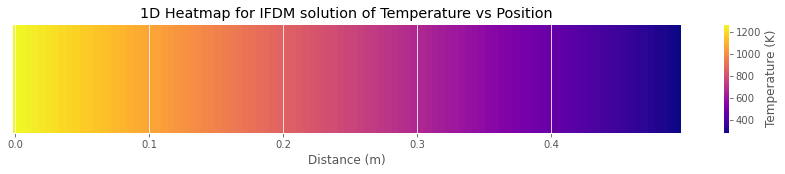

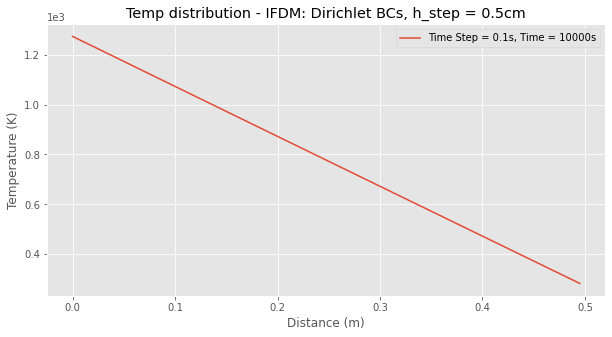

Gradient of slope: -1999.6590235969036


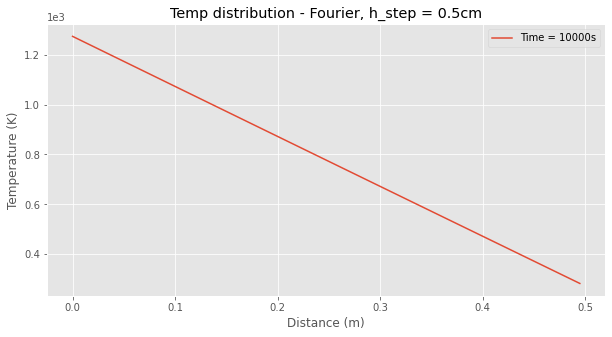

Gradient of slope: -2000.0673130633795


In [10]:
# Plot data, style and label - IDFM: Time= 5000s, Tau = 0.1s, h = 0.005m.
with plt.style.context('ggplot'): # Styles the plot.
    
    Label = str("Time Step = " + str(Tau_01) 
                + "s, " + "Time = " + str(Time_10000) + "s")
    plot_scatter_1dheat(Distance_0005
                        , U_List_10000_01
                        ,'Temp distribution - IFDM: ' + str(Condition) + ' BCs'
                        + ', h_step = ' + str(h*100) + "cm"
                        , 'Distance (m)'
                        , 'Temperature (K)'
                        , Label, True)
# Calculate the gradient of equillibrium state for IFDM

print('Gradient of slope: ' 
      + str(Gradient_Checker(Distance_0005, U_List_10000_01)))


# Plot Fourier Solution when Time = 5000s, h = 0.005m.
with plt.style.context('ggplot'): # Styles the plot
    
    Label = str("Time = " + str(Time_10000) + "s")
    plot_scatter_1dheat(Distance_Fourier
                        , U_Final_10000
                        , 'Temp distribution - Fourier, h_step = '
                        + str(h*100) + "cm"
                        , 'Distance (m)'
                        , 'Temperature (K)'
                        , Label, False)
    

print('Gradient of slope: ' 
      + str(Gradient_Checker(Distance_Fourier,U_Final_10000)))

In [11]:
# Boundary Condition.
Condition = 'Dirichlet'# 'Neumann' # 'Dirichlet'

# Parameters for IDFM and Fourier solution(s).
# Total time elapsed, s.
Time_100 = 100

# Time step sizes, s.
Tau_001 = 0.01 
Tau_01 = 0.1 
Tau_1 = 1 
Tau_5 = 5
Tau_10 = 10


# Run IFDM solution(s) for Time=100s, h = 0.005m with varying Tau.
Distance_0005, U_List_100_001 = Heat_Diffusion_Solver(Time_100
                                                         , Tau_001
                                                         , Condition)
Distance_0005, U_List_100_01 = Heat_Diffusion_Solver(Time_100
                                                       , Tau_01
                                                       , Condition)
Distance_0005, U_List_100_1 = Heat_Diffusion_Solver(Time_100
                                                     , Tau_1
                                                     , Condition)
Distance_0005, U_List_100_5 = Heat_Diffusion_Solver(Time_100
                                                     , Tau_5
                                                     , Condition)
Distance_0005, U_List_100_10 = Heat_Diffusion_Solver(Time_100
                                                     , Tau_10
                                                     , Condition)

# Run the Fourier Solution when Time = 100s, h = 0.005m.
Distance_Fourier, U_Final_100 = Fourier_solution(Time_100)

Integration error per coefficient: 8.222834465648991e-11


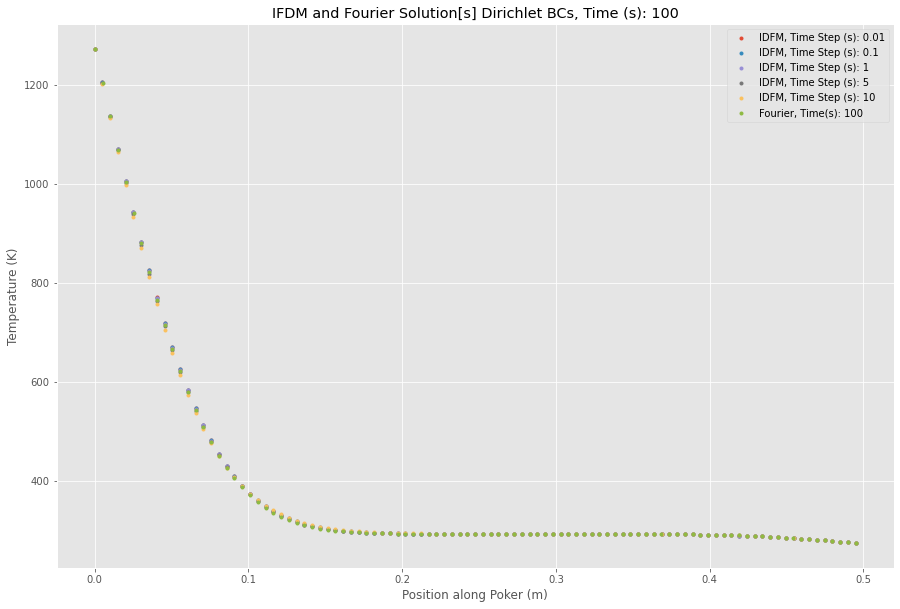

In [12]:
# Plot all IFDM and Fourier solution(s) for Time=100s, h = 0.005m with varying
# Tau for IFDM.
with plt.style.context('ggplot'):
    
        plt.rcParams["figure.figsize"] = 15,10 # Set size of plots in inches x,y.
        fig, ax = plt.subplots()
        
        plt.xlabel('Position along Poker (m)')
        plt.ylabel('Temperature (K)')
        plt.title('IFDM and Fourier Solution[s] '
                  + str(Condition) + ' BCs' + ', Time (s): ' + str(Time_100))
        
        Label ="IDFM, Time Step (s): " + str(Tau_001)
        plot_scatter(Distance_0005, U_List_100_001, Label)
        
        Label ="IDFM, Time Step (s): " + str(Tau_01)
        plot_scatter(Distance_0005, U_List_100_01, Label)
        
        Label ="IDFM, Time Step (s): " + str(Tau_1)
        plot_scatter(Distance_0005, U_List_100_1, Label)
        
        Label ="IDFM, Time Step (s): " + str(Tau_5)
        plot_scatter(Distance_0005, U_List_100_5, Label)
        
        Label ="IDFM, Time Step (s): " + str(Tau_10)
        plot_scatter(Distance_0005, U_List_100_10, Label)
        
        Label ="Fourier, Time(s): " + str(Time_100)
        plot_scatter(Distance_Fourier, U_Final_100, Label)
        
        plt.gca().legend() # Plots the legend.
        plt.show()
        
        

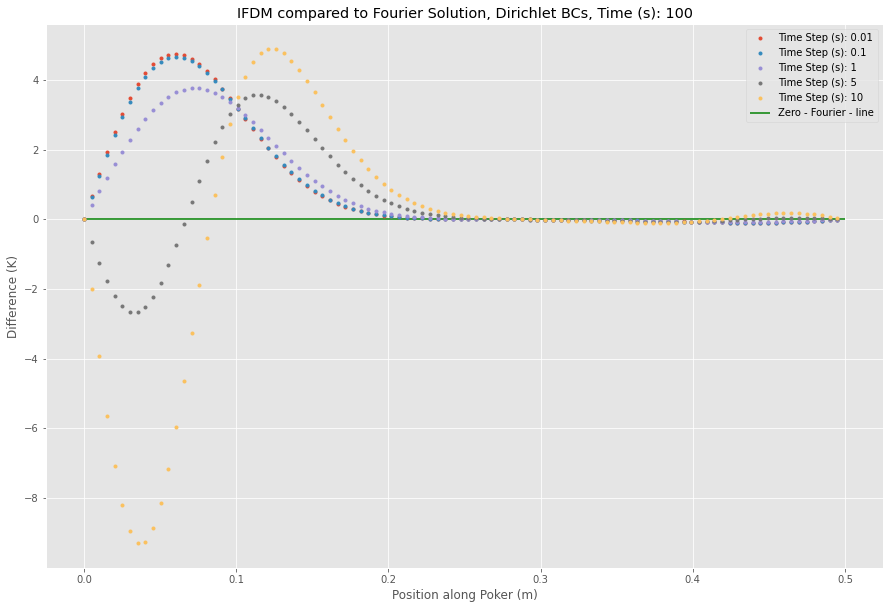

In [13]:
# Plot differences in IFDM and Fourier solutions for Time = 100s, h = 0.005m
# for varying Tau
with plt.style.context('ggplot'):
        plt.rcParams["figure.figsize"] = 15,10 # Set size of plots in inches x,y.
        fig, ax = plt.subplots()
        plt.xlabel('Position along Poker (m)')
        plt.ylabel('Difference (K)')
        plt.title('IFDM compared to Fourier Solution, '
                  + str(Condition) + ' BCs' + ', Time (s): ' + str(Time_100))
        
        Label = "Time Step (s): " + str(Tau_001)
        plot_scatter(Distance_0005,np.array(U_List_100_001) - U_Final_100,Label)
        
        Label = "Time Step (s): " + str(Tau_01)
        plot_scatter(Distance_0005,np.array(U_List_100_01) - U_Final_100,Label)
        
        Label = "Time Step (s): " + str(Tau_1)
        plot_scatter(Distance_0005,np.array(U_List_100_1) - U_Final_100,Label)
        
        Label = "Time Step (s): " + str(Tau_5)
        plot_scatter(Distance_0005,np.array(U_List_100_5) - U_Final_100,Label)
        
        Label = "Time Step (s): " + str(Tau_10)
        plot_scatter(Distance_0005,np.array(U_List_100_10) - U_Final_100,Label)

        plt.hlines(0, 0, 0.5
                   , color ='g'
                   , label = 'Zero - Fourier - line') 
        plt.gca().legend() # Plots the legend.
        plt.show()

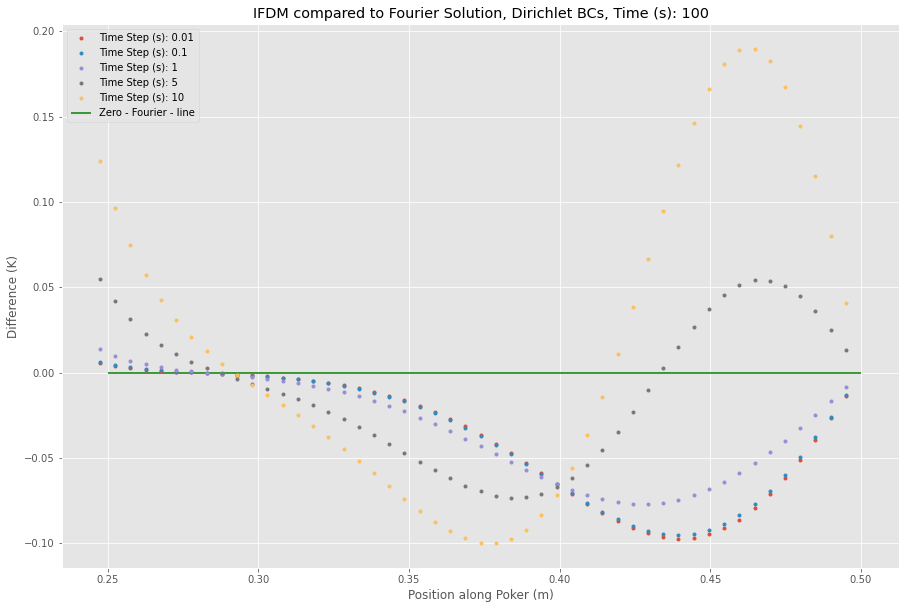

In [14]:
# Plot differences in IFDM and Fourier solutions for Time = 100s, h = 0.005m 
# for varying Tau - zoomed in second half of Graph
with plt.style.context('ggplot'):
        plt.rcParams["figure.figsize"] = 15,10 # Set size of plots in inches x,y.
        fig, ax = plt.subplots()
        plt.xlabel('Position along Poker (m)')
        plt.ylabel('Difference (K)')
        plt.title('IFDM compared to Fourier Solution, '
                  + str(Condition) + ' BCs' + ', Time (s): ' + str(Time_100))
        
        Label = "Time Step (s): "+ str(Tau_001)
        plot_scatter(Distance_0005[len(Distance_0005)//2:]
                     , np.array(U_List_100_001)[len(U_List_100_001)//2:] 
                     - U_Final_100[len(U_Final_100)//2:], Label)
        
        Label = "Time Step (s): "+ str(Tau_01)
        plot_scatter(Distance_0005[len(Distance_0005)//2:]
                     , np.array(U_List_100_01)[len(U_List_100_01)//2:] 
                     - U_Final_100[len(U_Final_100)//2:], Label)
        
        Label = "Time Step (s): "+ str(Tau_1)
        plot_scatter(Distance_0005[len(Distance_0005)//2:]
                     , np.array(U_List_100_1)[len(U_List_100_1)//2:] 
                     - U_Final_100[len(U_Final_100)//2:], Label)
        
        Label = "Time Step (s): "+ str(Tau_5)
        plot_scatter(Distance_0005[len(Distance_0005)//2:]
                     , np.array(U_List_100_5)[len(U_List_100_5)//2:] 
                     - U_Final_100[len(U_Final_100)//2:], Label)
        
        Label = "Time Step (s): "+ str(Tau_10)
        plot_scatter(Distance_0005[len(Distance_0005)//2:]
                     , np.array(U_List_100_10)[len(U_List_100_10)//2:] 
                     - U_Final_100[len(U_Final_100)//2:], Label)

        plt.hlines(0, 0.25, 0.5
                   , color ='g'
                   , label = 'Zero - Fourier - line') 
        plt.gca().legend() # Plots the legend.
        plt.show()

**Use this cell to discuss your code & results**
## PART 1 - Explanation

Important: 
These solutions, constants and parameters are in SI units **including** temperature.

This code finds the numerical solutions to the heat diffusion equation:

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$


In part 1 this is done by fixing one end of a metal poker into a fire/furnace and the other end into an ice bath. This was done using **Dirichlet** boundary conditions and the Implicit finite difference method, IFDM, in the matrix form: 

$$u^{n+1} = M^{-1}(u^{n} - b)$$

As both ends are fixed, the temperatures are evaluated for $N_{x}-2$ space points. 

Given the parameters of the poker and temperatures I solve the heat equations for a variety of times and time steps, however i keep the position step size h, constant throughout. So there are always 100 points (if you include the boundaries).

For a typical solution, the code works as follows:

- Define the parameters of Time (Time), Time step (Tau) and spacepoint step size (h) and condition (Condition = Dirichlet in this case). 

- Then the function: Heat_Diffusion_Solver() is called.
    - Heat_Diffusion_Solver() calls the two functions: U_Matrix_0_Create() and b_Matrix_Create which create the intial temperature values of the poker (excluding boundaries) and the boundary vector term for the Dirichlet boundary condition respectively.
    - The **M** matrix is created (which contains the collection of constant terms for the solution), and then inverted using LU decomposition (via a Linear algebra routine from Scipy: linalg.lu_factor()). 
    - Space point list is created for each step of size **h**.
    - Dot product of the inverse of the **M** matrix with the **u** matrix minus **b** matrix is then solved using linalg.lu_solve() for each time step until it has been solved to the desired Time value.
    - Fire/Furnace boundary is then added, along with position of poker in the fire.
    - It then returns two lists, the spacepoint list and the final temperature list.
- The lists are then plotted via the function plot_scatter_1dheat() which produces two graphs in a plot, a 1d heatmap and a scatter graph.
    
This is repeated a few times with different parameters to give a overview of the behaviour at different times (with the same time step).

Next, the code runs Heat_Diffusion_Solver() fives times for the same Time value, but different time step values (**Tau**) to observe changes in shape as a function of Tau. 

### EXTENSION:

This is then compared to the analytical Fourier solution which is created in the Fourier_solution() function. 

Fourier_solution() works by implementing the following function:

$$u(x,t) = u_{E}(x) + \sum \limits _{n=1} ^{N = 100} B_{n} sin\bigg(\frac{nx\pi}{L}\bigg) \exp\bigg({-kt\big(\frac{n\pi}{L}\big)^2}\bigg) $$

where:
$B_{n} = \frac{2}{L}  \int_{0}^{L} (T_{room} - u_{E}(x)) sin\big(\frac{nx\pi}{L}\big)) \,dx$ 

and, $u_{E}(x) = T_{F} + \frac{T_{I} - T_{F}}{L}x $
- $T_{F}$: Temperature of the fire/furnace,
- $T_{I}$: Temperature of the Ice(bath),
- $k$: Thermal diffusivity of the Poker,
- $L$: Length of Poker,
- $x$: spacepoint along the Poker,
- $t$: Time,
- $n$: order.



Using integrate.quad() from the scipy library and a lambda function to integrate the two x terms in functions f1() and f2().

This then produces the spacepoint list and temperature values evaluated for each spacepoint at time, Time, t.

First comparison is to just plot the IFDM solutions and Fourier solution onto one graph.

Secondly, a graph of the difference in temperature from the IFDM and Fourier solutions is then plotted at each space point for all data sets with varying Tau. 

Finally, a graph is plotted that is a zoomed in version of the previous graph to observe behaviour near the end closest to the ice bath.

#### Important notes on Fourier Solution:

This solution will have two sources of errors; 
Firstly in scipy integrate.quad() will have an error associated with it, this is apporximately 8.22e-11 per integration, so roughly a 8.22e-9 error per temperature value (given 100 orders of the coefficient). 

Secondly, the fourier solution contains an infinite sum, obviously this is not possible to recreate so I instead chose the order for the sum to be N = 100. This is a relatively large number of coefficient terms to have while still being able to compute it in a reasonable time. I havent quantified this but it would be possible by doing an integral test given a partial sum. I expect this number to be very small as is the error on the integration mentioned first. As such, I take the error on this method to be zero. This can be seen to be a satisfactory approximation given that the differences in values between IFDM and Fourier are of the order 1e1, nowhere close to 1e-9.

**Continued**

## PART 1 - Discussion

The first 3 sets of plots show the scatter and 1d heatmap graphs for the IFDM solution to the heat diffusion equation for time step 0.1s, spacepoint step 0.005m at times: 10s, 500s, 1000s and 10000s; alongside the Fourier solution with the same time(s). Qualatitively all four IFDM solutions match their respective fourier solutions very well.

They show the initial behaviour where the expression is dominated by an exponential decay, transforming slowly into an declined linear relationship when the poker comes into thermal equillibrium. This behaviour is expected and clearly observable.

In the plot for Time = 10000s, thermal equillibrium is being approached within the limit. This shows the declined linear relationship and a gradient is taken for both the IFDM and Fourier solution. IFDM Gradient = -1999.67 K/m, Fourier Gradient = -2000.07 K/m both of which are very close to the theoretical true gradient at thermal equillbrium of m = $\frac{T_{I} - T_{F}}{L}$ = -2000 K/m.

Meaning IFDM is off of the theoretical value by 0.0165% and the Fourier solution is off of the theoretical value by 0.0035%. Suggesting that the Fourier solution using 100 orders, is sufficient to use as a comparison to a very high precision; and that the IFDM method is roughly 5 (4.7) times less precise than the Fourier solution, but still very good.

Next, 6 plots are graphed onto a single graph. The first 5 plots are IFDM soltutions to the heat diffusion equation all at Time = 100s but with different time steps: 0.01s, 0.1s, 1s, 5s, 10s. With the final plot being the fourier solution at Time = 100s. From this very little difference between the different IFDM solutions can be observed, and all have the expected shape/behaviour.

The next plot then, is IFDM compared to the Fourier solution, found by taking the difference between the two solutions for the temperature values at the same time step. Here, it can be more clearly observed that the larger the time steps are the faster they deviate away and take longer to return to the fourier solution. With the exception of the time step value of 0.01s which seems to deviate away marginally faster than the 0.1s time step, but 0.01s does return faster than 0.1s does. This is somewhat unexpected, as I'd hypothesied that the smaller the time step the smaller the deviation. Given it should show more accurate behaviour for small length scales given a smaller time step. It is hard to see here if it returns faster than it deviates when compared to the time step 0.1s, i.e. if the area under the curve from 0 to ~0.25m  is smaller for the 0.01s data than it is for the 0.1s data. Further analysis would be required to dermine if it obeys the hypothesised rule (like the rest) or if it is indeed an outlier.

The final plot for part 1 is just a zoomed in version of the previous graph near the ice end of the poker. Here again we see larger deivations from the fourier solution for the data sets with larger time steps. But again the data for 0.01s appears to deviate away further than the 0.1s data.


## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two noces have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
}$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

In [15]:
# Boundary Condition.
Condition = 'Neumann'#'Neumann' # 'Dirichlet'

# Parameters for IDFM solution.
# Total times elapsed, s.

Time_100 = 100
Time_1000 = 1000
Time_10000 = 10000
Time_50000 = 50000
Time_100000 = 100000


# Time step size, s.
Tau_01 = 0.1 


# Distance step size, m.
h = 0.005 

# Run all IFDM solution(s) for Tau=0.1s, h = 0.005m with varying Time 
# for IFDM - Neumann

Distance_0005, U_List_100_01_N = Heat_Diffusion_Solver(Time_100
                                                       , Tau_01
                                                       , Condition)

Distance_0005, U_List_1000_01_N = Heat_Diffusion_Solver(Time_1000
                                                     , Tau_01
                                                     , Condition)

Distance_0005, U_List_10000_01_N = Heat_Diffusion_Solver(Time_10000
                                                     , Tau_01
                                                     , Condition)

Distance_0005, U_List_50000_01_N = Heat_Diffusion_Solver(Time_50000
                                                     , Tau_01
                                                     , Condition)

Distance_0005, U_List_100000_01_N = Heat_Diffusion_Solver(Time_100000
                                                     , Tau_01
                                                     , Condition)


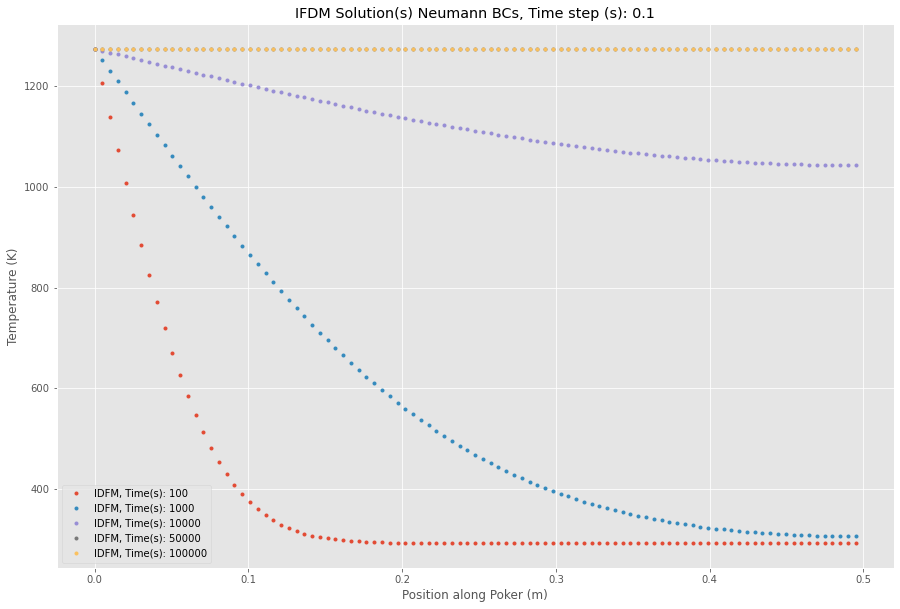

Gradient of slope, for Time = 50000s: -0.5668652919636432
Gradient of slope, for Time = 100000s: -0.00012234436511186441


In [16]:
# Plot all IFDM solution(s) for Tau=0.1s, h = 0.005m with varying Time
# for IFDM - Neumann

with plt.style.context('ggplot'):
    plt.rcParams["figure.figsize"] = 15,10 # Set size of plots in inches x,y.
    fig, ax = plt.subplots()

    plt.xlabel('Position along Poker (m)')
    plt.ylabel('Temperature (K)')
    plt.title('IFDM Solution(s) '
              + str(Condition) + ' BCs' + ', Time step (s): ' + str(Tau_01))


    Label ="IDFM, Time(s): " + str(Time_100)
    plot_scatter(Distance_0005, U_List_100_01_N, Label)

    Label ="IDFM, Time(s): " + str(Time_1000)
    plot_scatter(Distance_0005, U_List_1000_01_N, Label)

    Label ="IDFM, Time(s): " + str(Time_10000)
    plot_scatter(Distance_0005, U_List_10000_01_N, Label)
    
    Label ="IDFM, Time(s): " + str(Time_50000)
    plot_scatter(Distance_0005, U_List_50000_01_N, Label)

    Label ="IDFM, Time(s): " + str(Time_100000)
    plot_scatter(Distance_0005, U_List_100000_01_N, Label)
    


    plt.gca().legend() # Plots the legend.
    plt.show()

print('Gradient of slope, for Time = ' + str(Time_50000) + 's: '  
      + str(Gradient_Checker(Distance_Fourier, U_List_50000_01_N)))
print('Gradient of slope, for Time = ' + str(Time_100000) + 's: '  
      + str(Gradient_Checker(Distance_Fourier, U_List_100000_01_N)))

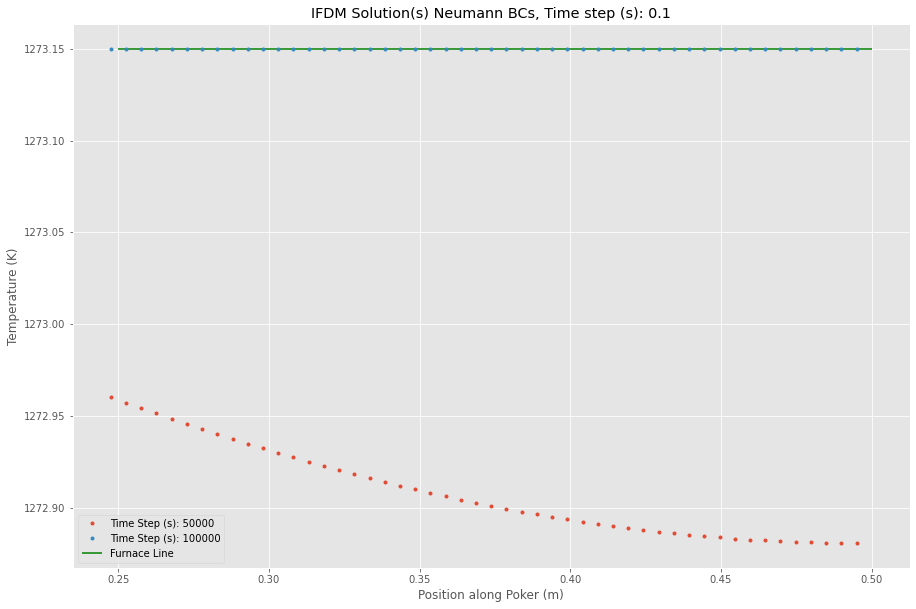

In [17]:
with plt.style.context('ggplot'):
        plt.rcParams["figure.figsize"] = 15,10 # Set size of plots in inches x,y
        fig, ax = plt.subplots()
        plt.xlabel('Position along Poker (m)')
        plt.ylabel('Temperature (K)')
        plt.title('IFDM Solution(s) '
              + str(Condition) + ' BCs' + ', Time step (s): ' + str(Tau_01))
        

        Label = "Time Step (s): "+ str(Time_50000)
        plot_scatter(Distance_0005[len(Distance_0005)//2:]
                     , np.array(U_List_50000_01_N)[len(U_List_50000_01_N)//2:] 
                     , Label)
        
        Label = "Time Step (s): "+ str(Time_100000)
        plot_scatter(Distance_0005[len(Distance_0005)//2:]
                     , np.array(U_List_100000_01_N)[len(U_List_100000_01_N)//2:] 
                     , Label)

        plt.hlines(1273.15, 0.25, 0.5
                   , color ='g'
                   , label = 'Furnace Line') 
        plt.gca().legend() # Plots the legend.
        plt.show()

**Use this cell to discuss your code & results**
## PART 2 - Explanation

This code finds also finds the numerical solutions to the heat diffusion equations. However, this time the ice bath boundary is no longer at its fixed temperature (273.15K) and is allowed to change, but not lose any heat.

This is acheived via Neumann boundary conditions.

Much of the code used in part 1 is used again here, with the exception of changing the boundary condition. This is done by changing the condition variable to 'Neumann' instead of 'Dirichlet'. 

In doing this, when M_Matrix_Create() and b_Matrix_Create() are called in the Heat_Diffusion_Solver() function, two slight changes are made. In the M matrix the last matrix element is replaced with 1 + alpha instead of 1+2alpha and in the b matrix the last matrix element is replaced with 0 instead of -alpha \* Temperature_Ice. In doing only these two minor changes, it keeps the furnace/fire end as a dirchlet condition and also allows the ice end to gain heat. 

Heat_Diffusion_Solver() is called with the Neumman boundary condition 5 times with a different value of Time, increasing in single orders of magnitude from 100s to 100,000s. This is done with time step 0.1s. 

These are then plotted onto a single graph. With then another graph plotted of the largest two time values.




## PART 2 - Discussion

In doing this, what we should observe is; for small time it will look similiarly to the behaviour seen in part 1. However, for large Time we will see the poker come into thermal equillibrium at the fire/furnace temperature, i.e with a slope of 0 across the poker.

What we observe in the first graph is indeed the expected behaviour. Times of 100s and 1000s look like the initial task with a marginal raise in the ice end temperature. Time 10,000s shows the transitional behaviour from our original Dirchlet behaviour to our expected Neumann behaviour. Finally values of 50,000 and 100,000s appear to be flat. Their gradients are taken and found to be -0.5669 K/m and -0.0001 K/m respectively. These gradients are to be expected as it approaches thermal equillibrium, the first derivative of temperature with respect to position should approach 0.

A close up on these two time values can be seen in the final graph where the smaller time value of 50,000s is seen to deviate away from the straight line near the end of the poker but only by about <1K. Where as the largest time value has no deviation or atleast a deviation no greater than $\pm$ 0.01K. These are all expected behaviours.